# Generate HuggingFace Dataset

## Imports

In [1]:
import os

import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, load_from_disk

from sentence_transformers import SentenceTransformer

In [2]:
from readability_scores import readability_scores
from lexical_density import lexical_density as Lexical_Density
from avg_word_sentence_length import average_word_length, average_sentence_length
from introduce_typo import introduce_typo
from TF_IDF import calc_tf_idf
from Add_Periods import Add_Periods

## Load dataset

### Loading prompts train csv

In [3]:
prompts_train = pd.read_csv('./data/prompts_train.csv')
prompts_train

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


### Loading summaries train csv

In [4]:
summaries_train = pd.read_csv('./data/summaries_train.csv')
summaries_train.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


## Readability Scores

In [5]:
text = """Although the algorithmic approach to readability has been criticized for not taking into account 
         the deeper, more fluid aspects of comprehension, such as motivation, background knowledge, 
         and personal interest, it's a useful tool for getting a general gauge on text's complexity."""

FK_grade, Gunning_Fog, SMOG = readability_scores(text)
print(f"Flesch-Kincaid Grade Level: {FK_grade:.2f}")
print(f"Gunning Fog Index: {Gunning_Fog:.2f}")
print(f"SMOG Index: {SMOG:.2f}")

Flesch-Kincaid Grade Level: 23.13
Gunning Fog Index: 26.50
SMOG Index: 21.19


In [6]:
text = "The quick brown fox jumps over the lazy dog"
noisy_text = introduce_typo(text, probability=0.2)
print(noisy_text)

The quick rown fox jumps ovre the lazy dog


## Lexical density

In [7]:
text = "The cat sat on the mat. The dog sat beside the cat."
print(f"Lexical Density: {Lexical_Density(text)}")

Lexical Density: 0.8571428571428571


## avg_word_sentence_length

In [8]:
text = "Hello world! This is a test. How long is the average sentence? Let's find out."

print(f"Average Word Length: {average_word_length(text):.2f}")
print(f"Average Sentence Length (in words): {average_sentence_length(text):.2f}")

Average Word Length: 5.09
Average Sentence Length (in words): 5.50


## TF-IDF

In [9]:
data1 = {
    'question': ['What is the theme of the text?'],
    'text': ["The short story revolves around a young girl's struggle during the Great Depression."]
}
data2 = {
    'question': ['Where did the event occur?'],
    'text': [ "The documentary narrates events in a small town in Spain during the 1800s."]
}
data3 = {
    'question': ['Who is the main character?'],
    'text': ["The novel centers on the adventures of a sailor named Odysseus."]
}

In [10]:
data={
    'question': prompts_train.loc[0]['prompt_question'],
    'text': prompts_train.loc[0]['prompt_text']
}

In [11]:
data

{'question': 'Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.',
 'text': 'Chapter 13 \r\nAs the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. \r\nA perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity 

In [12]:
word_score_df = calc_tf_idf(data['question'], data['text'], 10)
word_score_df

['tragedy',
 'tragic',
 'fear',
 'pity',
 'good',
 'like',
 'bad',
 'man',
 'best',
 'stage']

## BM25

In [13]:
class BM25:
    def __init__(self, corpus, k1=1.5, b=0.75):
        self.corpus = corpus
        self.k1 = k1
        self.b = b
        self.doc_lengths = [len(doc.split()) for doc in corpus]
        self.avgdl = sum(self.doc_lengths) / len(corpus)

    def score(self, query, doc):
        """
        Compute BM25 score for a given document and query.
        """
        doc_tokens = doc.split()
        query_tokens = query.split()
        score = 0.0
        
        for token in query_tokens:
            f = doc_tokens.count(token)
            score += (f * (self.k1 + 1)) / (f + self.k1 * (1 - self.b + self.b * len(doc_tokens) / self.avgdl))
            
        return score

    def rank(self, query):
        """
        Rank documents with respect to the given query.
        """
        scores = [(i, self.score(query, doc)) for i, doc in enumerate(self.corpus)]
        return sorted(scores, key=lambda x: x[1], reverse=True)


# Example
corpus = [
    "The cat sat on the mat",
    "The dog sat on the log",
    "Cats and dogs are animals"
]

bm25 = BM25(corpus)
query = "cat on mat"
ranking = bm25.rank(query)
print(ranking)


[(0, 2.922636103151863), (1, 0.9742120343839542), (2, 0.0)]


In [14]:
import re

query, text = data['question'], data['text']
# Splitting the provided text into sentences
sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text.replace('\r\n', ' '))
# Applying BM25 to rank sentences
bm25 = BM25(sentences)
ranking = bm25.rank(query)
# Getting top 3 ranked sentences
top_sentences = [sentences[i[0]] for i in ranking[:3]]

for i, sentence in enumerate(top_sentences, 1):
    print(f"{i}. {sentence}\n")

1. A tragedy, then, to be perfect according to the rules of art, should be of this construction.

2. It should come about as the result not of vice, but of some great error or frailty, in a character either such as we have described, or better rather than worse.

3. It is accounted the best because of the weakness of the spectators; for the poet is guided in what he writes by the wishes of his audience.



## Generate HF Dataset

### Load sentence transformers model

In [15]:
model = SentenceTransformer('all-mpnet-base-v2')

### Preprocess prompts dataset

In [16]:
def preprocess_prompts(prompts_df: pd.DataFrame) -> pd.DataFrame:
    # init an empty new  dataFrame
    new_data = pd.DataFrame({
        'prompt_id': [],
        'prompt_question': [],
        # 'prompt_title': [],
        'prompt_text': []
    })

    for index, row in prompts_df.iterrows():
        # retrieve columns
        prompt_id = row['prompt_id']
        prompt_question = row['prompt_question']
        # prompt_title = row['prompt_title'] # we do not need the title
        prompt_text = row['prompt_text']

        # we are creating a batch of the sentences we want to get embeddings
        sentences = [prompt_question, prompt_text]

        # calling model embedding
        embeddings = model.encode(sentences)

        # Create a new row
        new_row = pd.DataFrame({'prompt_id': [prompt_id], 'prompt_question': [embeddings[0]], 'prompt_text': [embeddings[1]]})
        
        # Append the row
        new_data = pd.concat([new_data.loc[:], new_row], ignore_index=True)

    path = f"./data/preprocessed_data"
    os.makedirs(path, exist_ok=True)
    new_data.to_pickle(f"{path}/prompts_train.pickle")
    return new_data

In [17]:
preprocessed_prompts_train = preprocess_prompts(prompts_train)
preprocessed_prompts_train

,prompt_id,prompt_question,prompt_text
0,39c16e,"[0.0091599105, -0.029818784, 0.0031730002, 0.0...","[-0.010795923, 0.025710443, -0.015630066, 0.01..."
1,3b9047,"[-0.012024703, 0.016922273, 0.015488309, 0.002...","[0.058067385, 0.042484563, 0.012715496, 0.0067..."
2,814d6b,"[0.054656938, -0.06503344, 0.011860348, -0.053...","[0.04722372, 0.06517054, 0.00032050064, -0.025..."
3,ebad26,"[0.0067965747, 0.07661588, -0.009160591, 0.033...","[-0.013152148, 0.059951786, -0.0068048476, -0...."


### Preprocess summaries dataset

In [18]:
def normalize_value(x, min=-2, max=4):
    return 2*((x-min)/(max-min))-1

In [19]:
def preprocess_summaries(summaries_df: pd.DataFrame, prompts_df: pd.DataFrame) -> pd.DataFrame :
    # init an empty new  dataFrame
    new_data = pd.DataFrame({
        'student_id': [],
        'prompt_id': [],
        'prompt_question': [],
        'prompt_text': [],
        'text': [],
        'fk_grade': [],
        'gunning_fog': [],
        'smog': [],
        'lexical_density': [],
        'avg_word_length': [],
        'avg_sentence_length': [],
        'content': [],
        'wording': [],
        'normalized_content': [],
        'normalized_wording': []
    })
    
    for index, row in summaries_df.iterrows():
        print(f"\r{index+1}/{len(summaries_df)}", end="")
        # retrieve columns
        student_id = row["student_id"]
        prompt_id = row["prompt_id"]
        text = row["text"]
        content = row["content"]
        wording = row["wording"]
        # space behind period of end of sentence "Exemple end.Start new sentence text@gmail.com" = "Exemple end. Start new sentence text@gmail.com" 
        text = re.sub(r'(?<=\.)[A-Z]', r' \g<0>', text)
        text = Add_Periods(text)
        
        
        FK_grade, Gunning_Fog, SMOG = readability_scores(text)
        lexical_density = Lexical_Density(text)
        avg_word_length = average_word_length(text)
        avg_sentence_length = average_sentence_length(text)
        normalized_content = normalize_value(content)
        normalized_wording = normalize_value(wording)

        # we are creating a batch of the sentences we want to get embeddings
        sentences = [text]

        # calling model embedding
        embeddings = model.encode(sentences)

        prompt_row = prompts_df.loc[prompts_df['prompt_id'] == prompt_id]
        prompt_question, prompt_text = prompt_row['prompt_question'].item(), prompt_row['prompt_text'].item()

        # Create a new row
        new_row = pd.DataFrame({
            'student_id': [student_id],
            'prompt_id': [prompt_id],
            'prompt_question': [prompt_question],
            'prompt_text': [prompt_text],
            'text': [embeddings[0]],
            'fk_grade': [FK_grade],
            'gunning_fog': [Gunning_Fog],
            'smog': [SMOG],
            'lexical_density': [lexical_density],
            'avg_word_length': [avg_word_length],
            'avg_sentence_length': [avg_sentence_length],
            'content': [content],
            'wording': [wording],
            'normalized_lexical_density': [normalize_value(lexical_density, min=0, max=1)],
            'normalized_avg_word_length': [normalize_value(avg_word_length, min=3, max=10)],
            'normalized_avg_sentence_length': [normalize_value(avg_sentence_length, min=3, max=60)],
            'normalized_fk_grade': [normalize_value(FK_grade, min=0, max=27)],
            'normalized_gunning_fog': [normalize_value(Gunning_Fog, min=0, max=30)],
            'normalized_smog': [normalize_value(SMOG, min=0, max=23)],
            'normalized_content': [normalized_content],
            'normalized_wording': [normalized_wording]
        })
        
        # Append the row
        new_data = pd.concat([new_data.loc[:], new_row], ignore_index=True)

    path = f"./data/preprocessed_data"
    os.makedirs(path, exist_ok=True)
    new_data.to_pickle(f"{path}/summaries_train.pickle") 
    return new_data

In [20]:
preprocess_summaries_train = preprocess_summaries(summaries_train, preprocessed_prompts_train)
preprocess_summaries_train

7165/7165

,student_id,prompt_id,prompt_question,prompt_text,text,fk_grade,gunning_fog,smog,lexical_density,avg_word_length,...,content,wording,normalized_content,normalized_wording,normalized_lexical_density,normalized_avg_word_length,normalized_avg_sentence_length,normalized_fk_grade,normalized_gunning_fog,normalized_smog
0,000e8c3c7ddb,814d6b,"[0.054656938, -0.06503344, 0.011860348, -0.053...","[0.04722372, 0.06517054, 0.00032050064, -0.025...","[0.041094355, -0.006460443, 0.008264857, -0.06...",9.121434,11.345902,11.208143,0.875000,5.312500,...,0.205683,0.380538,-0.264772,-0.206487,0.750000,-0.339286,-0.684211,-0.324338,-0.243607,-0.025379
1,0020ae56ffbf,ebad26,"[0.0067965747, 0.07661588, -0.009160591, 0.033...","[-0.013152148, 0.059951786, -0.0068048476, -0....","[0.033534568, 0.112103865, 0.013419032, 0.0166...",7.938462,10.400000,3.129100,0.805556,4.166667,...,-0.548304,0.506755,-0.516101,-0.164415,0.611111,-0.666667,-0.473684,-0.411966,-0.306667,-0.727904
2,004e978e639e,3b9047,"[-0.012024703, 0.016922273, 0.015488309, 0.002...","[0.058067385, 0.042484563, 0.012715496, 0.0067...","[0.02383808, 0.028919337, 0.015478168, -0.0004...",7.173276,9.807630,10.056822,0.731183,5.456989,...,3.128928,4.231226,0.709643,1.077075,0.462366,-0.298003,-0.723426,-0.468646,-0.346158,-0.125494
3,005ab0199905,3b9047,"[-0.012024703, 0.016922273, 0.015488309, 0.002...","[0.058067385, 0.042484563, 0.012715496, 0.0067...","[0.041241955, -0.01394414, 0.015658101, 0.0315...",4.418571,7.085714,8.076483,0.818182,5.636364,...,-0.210614,-0.471415,-0.403538,-0.490472,0.636364,-0.246753,-0.943860,-0.672698,-0.527619,-0.297697
4,0070c9e7af47,814d6b,"[0.054656938, -0.06503344, 0.011860348, -0.053...","[0.04722372, 0.06517054, 0.00032050064, -0.025...","[0.008489414, 0.042291302, 0.012424187, -0.051...",9.346080,13.271777,12.540901,0.787500,5.712500,...,3.272894,3.219757,0.757631,0.739919,0.575000,-0.225000,-0.704261,-0.307698,-0.115215,0.090513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,"[0.0067965747, 0.07661588, -0.009160591, 0.033...","[-0.013152148, 0.059951786, -0.0068048476, -0....","[0.046876807, 0.03582544, -0.0273565, -0.00767...",4.324286,7.428571,8.418075,0.830189,4.698113,...,0.205683,0.380538,-0.264772,-0.206487,0.660377,-0.514825,-0.868421,-0.679683,-0.504762,-0.267993
7161,ffc34d056498,3b9047,"[-0.012024703, 0.016922273, 0.015488309, 0.002...","[0.058067385, 0.042484563, 0.012715496, 0.0067...","[-0.035234254, 0.033364758, 0.02028155, 0.0068...",5.616453,6.160465,7.168622,0.862069,6.034483,...,-0.308448,0.048171,-0.436149,-0.317276,0.724138,-0.133005,-0.850877,-0.583966,-0.589302,-0.376642
7162,ffd1576d2e1b,3b9047,"[-0.012024703, 0.016922273, 0.015488309, 0.002...","[0.058067385, 0.042484563, 0.012715496, 0.0067...","[0.022816774, 0.011155369, -0.0006411369, 0.02...",9.618061,11.432653,8.841846,0.923077,5.000000,...,-1.408180,-0.493603,-0.802727,-0.497868,0.846154,-0.428571,-0.637427,-0.287551,-0.237823,-0.231144
7163,ffe4a98093b2,39c16e,"[0.0091599105, -0.029818784, 0.0031730002, 0.0...","[-0.010795923, 0.025710443, -0.015630066, 0.01...","[0.011485147, -0.04918704, -0.0018216049, -0.0...",5.562500,8.611864,8.841846,0.813953,4.627907,...,-0.393310,0.627128,-0.464437,-0.124291,0.627907,-0.534884,-0.728070,-0.587963,-0.425876,-0.231144


In [21]:
print("fk_grade: ", preprocess_summaries_train['fk_grade'].min(), preprocess_summaries_train['fk_grade'].max())
print("gunning_fog: ", preprocess_summaries_train['gunning_fog'].min(), preprocess_summaries_train['gunning_fog'].max())
print("smog: ", preprocess_summaries_train['smog'].min(), preprocess_summaries_train['smog'].max())
print("lexical_density: ", preprocess_summaries_train['lexical_density'].min(), preprocess_summaries_train['lexical_density'].max())
print("avg_word_length: ", preprocess_summaries_train['avg_word_length'].min(), preprocess_summaries_train['avg_word_length'].max())
print("avg_sentence_length: ", preprocess_summaries_train['avg_sentence_length'].min(), preprocess_summaries_train['avg_sentence_length'].max())

fk_grade:  0.7588118811881195 26.71776595744681
gunning_fog:  2.4000000000000004 29.61843971631206
smog:  3.1291 22.076135915942103
lexical_density:  0.3257918552036199 1.0
avg_word_length:  3.5 7.7727272727272725
avg_sentence_length:  3.111111111111111 56.5


-----

## Correlation

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

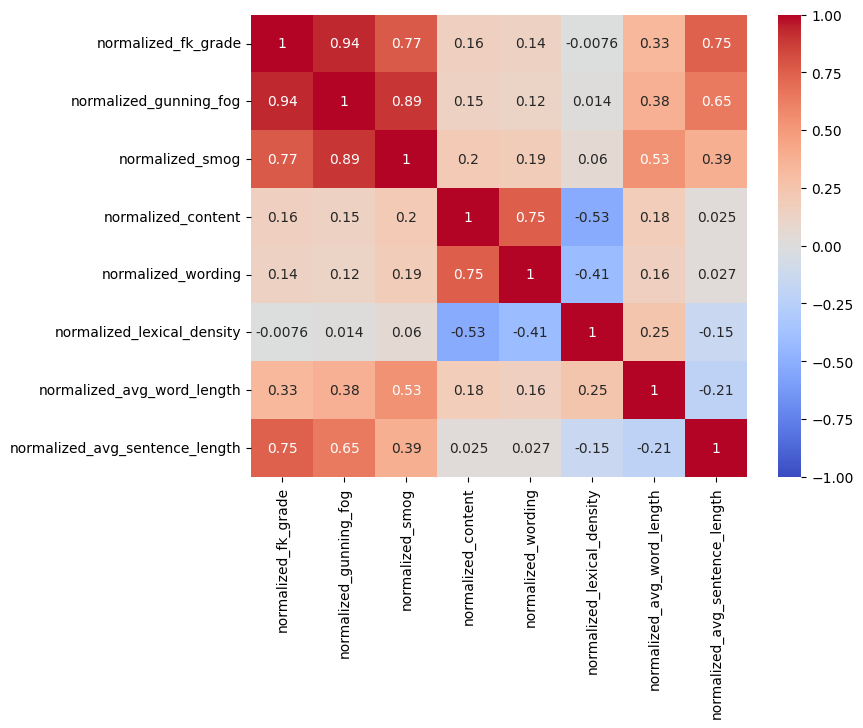

In [23]:
corr_df = preprocess_summaries_train[[
    'normalized_fk_grade',
    'normalized_gunning_fog',
    'normalized_smog',
    'normalized_content',
    'normalized_wording',
    'normalized_lexical_density',
    'normalized_avg_word_length',
    'normalized_avg_sentence_length',
]]
# Compute the correlation matrix
correlation_matrix = corr_df.corr()
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

# Show the plot
plt.show()

In [24]:
assert "a" == "b", "Stop"

AssertionError: Stop

### Testing lisibility

In [27]:
index_of_max_content = preprocess_summaries_train['gunning_fog'].idxmin()
preprocess_summaries_train.loc[index_of_max_content]

student_id                                                             5d227fb82793
prompt_id                                                                    3b9047
prompt_question                   [-0.012024703, 0.016922273, 0.015488309, 0.002...
prompt_text                       [0.058067385, 0.042484563, 0.012715496, 0.0067...
text                              [-0.03125951, 0.0027180098, 0.0024800522, 0.02...
fk_grade                                                                   1.172222
gunning_fog                                                                     2.4
smog                                                                         3.1291
lexical_density                                                            0.785714
avg_word_length                                                                4.25
avg_sentence_length                                                        4.666667
content                                                                   -0

In [26]:
t = summaries_train.loc[index_of_max_content]['text']
t

'The Egyptian government  had many diffrent areas tht were completely diffrent for example the pharoh was like thier king and the soilders they would just protect they would even get to chose shat they even eat if they were luck the soldiers would have bread that was not that stel so there was a big diffrence bettwen but when there is poor in rich there are peole in the middle and those people were the nobles and the preist they were high above they had some poer but not that much the preist would have many diffrent choices for food and he would be able to talk to the other gods and pray and chant diffrent things his job was to please the gods. The nobles would make the laws ad keep the religoin they were one tier under the pheroh.'

In [28]:
FK_grade, Gunning_Fog, SMOG = readability_scores(text)
FK_grade, Gunning_Fog, SMOG

(11.096333333333334, 15.133333333333335, 13.538219098175407)

In [36]:
specific_prompt_id = '814d6b'
index_of_max_content = preprocess_summaries_train[preprocess_summaries_train['prompt_id'] == specific_prompt_id]['smog'].idxmax()
preprocess_summaries_train.loc[index_of_max_content]

student_id                                                             6b1bf13b2fc9
prompt_id                                                                    814d6b
prompt_question                   [0.054656938, -0.06503344, 0.011860348, -0.053...
prompt_text                       [0.04722372, 0.06517054, 0.00032050064, -0.025...
text                              [0.0022784588, 0.057725042, -0.0023785806, -0....
fk_grade                                                                  22.197447
gunning_fog                                                               26.885106
smog                                                                      20.736967
lexical_density                                                            0.777778
avg_word_length                                                            6.206349
avg_sentence_length                                                       21.333333
content                                                                    0

In [37]:
specific_prompt_id = '814d6b'
index_of_max_content = preprocess_summaries_train[preprocess_summaries_train['prompt_id'] == specific_prompt_id]['wording'].idxmax()
preprocess_summaries_train.loc[index_of_max_content]

student_id                                                             b257979693a2
prompt_id                                                                    814d6b
prompt_question                   [0.054656938, -0.06503344, 0.011860348, -0.053...
prompt_text                       [0.04722372, 0.06517054, 0.00032050064, -0.025...
text                              [0.030327868, 0.050637636, 0.007928227, -0.026...
fk_grade                                                                   7.633936
gunning_fog                                                               10.232228
smog                                                                      10.317481
lexical_density                                                            0.717391
avg_word_length                                                            5.384058
avg_sentence_length                                                            11.5
content                                                                    3

----

In [ ]:
preprocess_summaries_train = pd.read_pickle("./data/preprocessed_data/summaries_train.pickle")

In [ ]:
preprocess_summaries_train

### Serialize and deserialize functions

In [ ]:
def serialize_array(arr):
    return arr.tobytes()
    
def deserialize_array(binary_string, dtype, shape):
    return np.frombuffer(binary_string, dtype=dtype).reshape(shape)

In [ ]:
def preprocess_data(data):
    data['prompt_question'] = data['prompt_question'].apply(serialize_array)
    data['prompt_text'] = data['prompt_text'].apply(serialize_array)
    data['text'] = data['text'].apply(serialize_array)
    return data

In [ ]:
preprocess_summaries_train = preprocess_data(preprocess_summaries_train)

### Converting the pandas dataset to huggingFace dataset

In [ ]:
train_dataset = Dataset.from_pandas(preprocess_summaries_train)

In [ ]:
dataset = {
    'train': train_dataset,
}

In [ ]:
dataset = DatasetDict(dataset)
path = './data/hugging_face/'
os.makedirs(path, exist_ok=True)
dataset.save_to_disk(path)

### Test the HF dataset

In [ ]:
# Later you can load the entire DatasetDict back from disk like this
dataset_dict = DatasetDict.load_from_disk(path)

In [ ]:
print(dataset_dict)
print()
print(deserialize_array(dataset_dict['train'][0]['prompt_question'], np.float32, (768)).shape)
print()
print(deserialize_array(dataset_dict['train'][0]['prompt_text'], np.float32, (768)).shape)
print()
print(deserialize_array(dataset_dict['train'][0]['text'], np.float32, (768)).shape)
print()
print(dataset_dict['train'][0]['content'])
print()
print(dataset_dict['train'][0]['normalized_content'])